# This notebook contains an analysis of the multi-hazard risk in the Kathmandu Valley

In [1]:
# Import all libraries needed for this notebook
import geopandas as gpd
import pandas as pd
import numpy as np
import rasterio.mask
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
from collections import Counter
from scipy.spatial import cKDTree
from rasterio.features import rasterize,geometry_mask

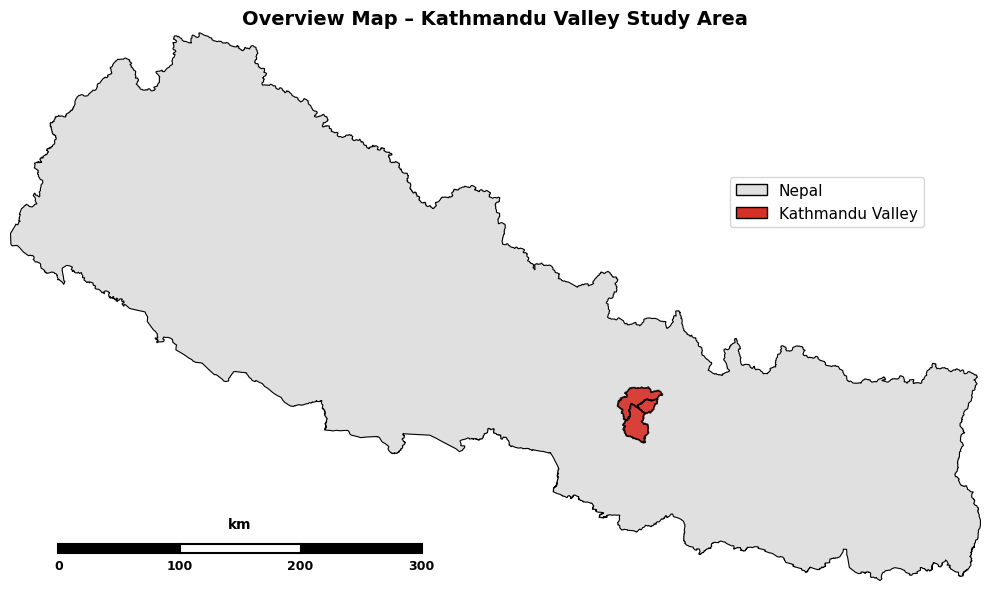

In [2]:
# Load data
country_path = "input1/nepal_country.gpkg"
valley_path = "input1/kathmandu_valley_reprojected.gpkg"

nepal = gpd.read_file(country_path)
valley = gpd.read_file(valley_path)

# Harmonize CRS
if nepal.crs != valley.crs:
    valley = valley.to_crs(nepal.crs)

# Create plot
fig, ax = plt.subplots(figsize=(10, 10))

# Plot Nepal in gray
nepal.plot(ax=ax, color="#e0e0e0", edgecolor="black", linewidth=0.8)

# Highlight Kathmandu Valley in red
valley.plot(ax=ax, color="#d73027", edgecolor="black", linewidth=1.2, alpha=0.9)

# Title
ax.set_title(
    "Overview Map – Kathmandu Valley Study Area",
    fontsize=14,
    fontweight="bold"
)

# Set view to full Nepal extent
ax.set_xlim(nepal.total_bounds[0], nepal.total_bounds[2])
ax.set_ylim(nepal.total_bounds[1], nepal.total_bounds[3])

# Legend
legend_elements = [
    mpatches.Patch(facecolor="#e0e0e0", edgecolor='black', label='Nepal'),
    mpatches.Patch(facecolor="#d73027", edgecolor='black', label='Kathmandu Valley')
]
ax.legend(
    handles=legend_elements,
    loc='upper right',
    bbox_to_anchor=(0.95, 0.75),
    fontsize=11,
    frameon=True,
    title_fontsize=12
)

# Scale bar
x_min, y_min, x_max, y_max = nepal.total_bounds
scale_x = x_min + (x_max - x_min) * 0.05
scale_y = y_min + (y_max - y_min) * 0.05

# Convert km to CRS units
segment_km = 100
if nepal.crs.is_geographic:
    segment_length = segment_km / 111
else:
    segment_length = segment_km * 1000

# Bar height
bar_height = (y_max - y_min) * 0.015

# Draw three segments: black, white, black
colors = ['black', 'white', 'black']
for i, color in enumerate(colors):
    rect = mpatches.Rectangle(
        (scale_x + i * segment_length, scale_y),
        segment_length,
        bar_height,
        facecolor=color,
        edgecolor='black',
        linewidth=1.5
    )
    ax.add_patch(rect)

# Labels below segment boundaries
for i in range(4):
    x_pos = scale_x + i * segment_length
    ax.text(x_pos, scale_y - (y_max - y_min) * 0.03,
            f'{i * segment_km}',
            ha='center', fontsize=9, fontweight='bold')

# km label
ax.text(scale_x + 1.5 * segment_length, scale_y + bar_height + (y_max - y_min) * 0.03,
        'km',
        ha='center', fontsize=10, fontweight='bold')

ax.set_axis_off()
plt.tight_layout()
plt.show()

In [4]:
# Define colors for all plots
colors = {
    "Low": "#a6d96a",
    "Moderate": "#fee08b",
    "High": "#f46d43",
    "Very High": "#7f0000"
}

c:\Users\Nutzer\miniforge3\envs\3D_analysis_norcia\Lib\site-packages\geopandas\tools\overlay.py:358: UserWarning: `keep_geom_type=True` in overlay resulted in 198 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  result = _collection_extract(result, geom_type, keep_geom_type_warning)


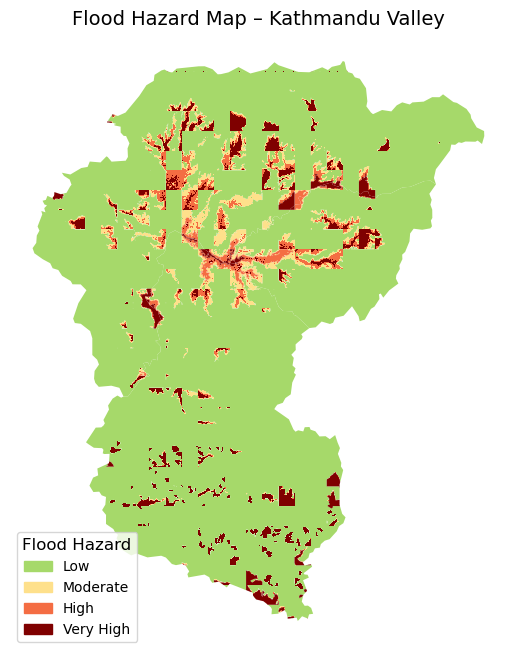

In [ ]:
# Load input data
valley = gpd.read_file("input1/kathmandu_valley_reprojected.gpkg")
wl2 = gpd.read_file("input1/floods/waterlevel_2m.gpkg")
wl10 = gpd.read_file("input1/floods/waterlevel_10m.gpkg")
wl20 = gpd.read_file("input1/floods/waterlevel_20m.gpkg")

# Harmonize CRS
crs = valley.crs
wl2 = wl2.to_crs(crs)
wl10 = wl10.to_crs(crs)
wl20 = wl20.to_crs(crs)

# Very High: 2m flood areas
very_high = gpd.overlay(valley, wl2, how="intersection")
very_high["hazard"] = "Very High"

# High: 10m but not 2m
high = gpd.overlay(valley, wl10, how="intersection")
high = gpd.overlay(high, wl2, how="difference")
high["hazard"] = "High"

# Moderate: 20m but not 10m
moderate = gpd.overlay(valley, wl20, how="intersection")
moderate = gpd.overlay(moderate, wl10, how="difference")
moderate["hazard"] = "Moderate"

# Low: rest of valley without flood areas
flood_union = pd.concat([very_high, high, moderate], ignore_index=True)
flood_union = gpd.GeoDataFrame(flood_union, crs=crs)
low = gpd.overlay(valley, flood_union, how="difference")
low["hazard"] = "Low"

# Combine all hazard classes
hazards = gpd.GeoDataFrame(
    pd.concat([low, moderate, high, very_high], ignore_index=True),
    crs=crs
)

# Save output
hazards.to_file("output/floods.gpkg", driver="GPKG")

# Plot map
fig, ax = plt.subplots(figsize=(10, 8))


# Plot hazard areas
hazards.plot(
    ax=ax,
    color=hazards["hazard"].map(colors),
    edgecolor="none"
)

# Create legend
legend_patches = [
    mpatches.Patch(color=colors["Low"], label="Low"),
    mpatches.Patch(color=colors["Moderate"], label="Moderate"),
    mpatches.Patch(color=colors["High"], label="High"),
    mpatches.Patch(color=colors["Very High"], label="Very High")
]
ax.legend(
    handles=legend_patches,
    title="Flood Hazard",
    loc="lower left",
    fontsize=10,
    title_fontsize=12
)
ax.set_title("Flood Hazard Map – Kathmandu Valley", fontsize=14)
ax.set_axis_off()
plt.show()

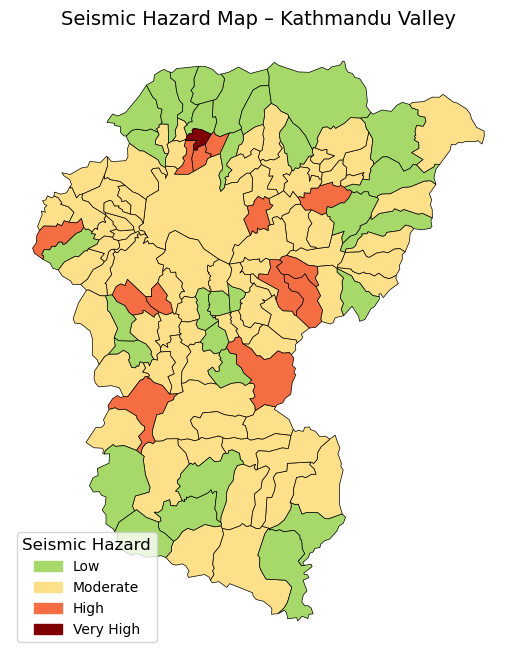

In [5]:
# Load input data
districts = gpd.read_file("input1/kathmandu_valley_districs.gpkg")
pga = gpd.read_file("input1/seismic/seismic_kathmandu_reprojected.gpkg")

# Harmonize CRS
crs = districts.crs
pga = pga.to_crs(crs)

# Calculate mean PGA per district
districts['PGA_mean'] = districts.geometry.apply(
    lambda poly: pga[pga.within(poly)]['PGA-0.1'].mean()
)

# IDW interpolation for districts with missing data
coords = np.array([(pt.x, pt.y) for pt in pga.geometry])
values = np.array(pga['PGA-0.1'])

# District centroids with missing PGA
missing_idx = districts[districts['PGA_mean'].isna()].index
centroids = np.array([districts.loc[i].geometry.centroid.coords[0] for i in missing_idx])

# IDW calculation
def idw(xy, values, query, k=5, power=2):
    tree = cKDTree(xy)
    dists, idxs = tree.query(query, k=k)
    dists[dists==0] = 1e-10
    weights = 1 / dists**power
    return np.sum(weights * values[idxs], axis=1) / np.sum(weights, axis=1)

interpolated = idw(coords, values, centroids)
districts.loc[missing_idx, 'PGA_mean'] = interpolated

# Create hazard categories
bins = [0, 0.52, 0.58, 0.64, np.inf]
labels = ['Low', 'Moderate', 'High', 'Very High']
districts['hazard'] = pd.cut(districts['PGA_mean'], bins=bins, labels=labels)

# Save output
districts.to_file("output/earthquake_hazards.gpkg", driver="GPKG")

# Plot map
fig, ax = plt.subplots(figsize=(10, 8))
districts.plot(ax=ax, color=districts['hazard'].map(colors), edgecolor="black", linewidth=0.5)

# Legend
legend_patches = [mpatches.Patch(color=colors[l], label=l) for l in labels]
ax.legend(handles=legend_patches, title="Seismic Hazard", loc="lower left", fontsize=10, title_fontsize=12)
ax.set_title("Seismic Hazard Map – Kathmandu Valley", fontsize=14)
ax.set_axis_off()
plt.show()

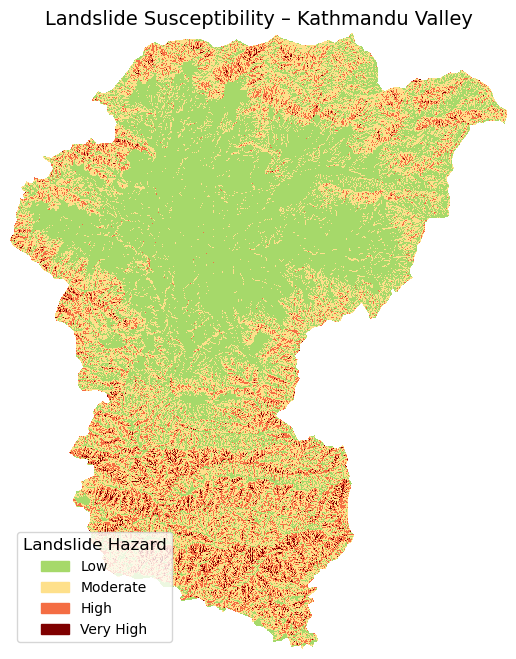

Unique Werte im gesamten Raster: [0.         0.03063999 0.03065109 ... 0.6535187  0.65722984 0.6580741 ]
Min: 0.0
Max: 0.6580741
Pixel 0: 0.41111642122268677
Pixel 4: 0.05358835309743881
Pixel 5: 0.0
Pixel 7: 0.21367564797401428
Pixel 9: 0.0
Hazard-Klassen-Verteilung: {np.int64(0): np.int64(340145), np.int64(1): np.int64(172250), np.int64(2): np.int64(371797), np.int64(3): np.int64(136242), np.int64(4): np.int64(15878)}


In [9]:
# load data
valley = gpd.read_file("input1/kathmandu_valley_reprojected.gpkg")
raster_path = "input1/landslide/Landslide_suspectibility_30m.tif"

# clip to valley
with rasterio.open(raster_path) as src:
    # Crop auf Bounding Box
    out_image, out_transform = rasterio.mask.mask(
        src, valley.geometry, crop=True, filled=False
    )
    out_meta = src.meta.copy()
    
    # create mask
    mask_polygon = geometry_mask(
        valley.geometry,
        out_shape=out_image.shape[1:],  # (height, width)
        transform=out_transform,
        invert=False  
    )

data = out_image[0]

# extract values
if isinstance(data, np.ma.MaskedArray):
    data_values = data.data.copy()
else:
    data_values = data.copy()

# areas inside the polygo set to 0
inside_polygon = ~mask_polygon
data_values[inside_polygon & (data_values < 0.01)] = 0  # small values = no landslide

bins = [0, 0.15, 0.30, 0.45, 1.0]
colors = ["#a6d96a", "#fee08b", "#f46d43", "#7f0000"]
labels = ["Low", "Moderate", "High", "Very High"]

# classifier
hazard = np.digitize(data_values, bins, right=True)

hazard_masked = np.ma.array(hazard, mask=mask_polygon)

# plot map
cmap = ListedColormap(colors)
cmap.set_bad(color='white', alpha=0)

fig, ax = plt.subplots(figsize=(10, 8))

im = ax.imshow(hazard_masked, cmap=cmap, vmin=1, vmax=4, interpolation='nearest')
ax.set_title("Landslide Susceptibility – Kathmandu Valley", fontsize=14)
ax.set_axis_off()

# legend
legend_patches = [mpatches.Patch(color=colors[i], label=labels[i]) for i in range(4)]
ax.legend(
    handles=legend_patches, 
    title="Landslide Hazard", 
    loc="lower left", 
    fontsize=10, 
    title_fontsize=12
)

plt.show()

# new array with 0 outside the valley
hazard_filled = hazard.copy().astype(np.uint8)
hazard_filled[mask_polygon] = 0  # 0 = NoData / outside

# Metadaten anpassen
out_meta.update({
    "dtype": "uint8",
    "nodata": 0
})

# seve raster
with rasterio.open("output/landslide_hazard.tif", "w", **out_meta) as dst:
    dst.write(hazard_filled, 1)

print("Unique Werte im gesamten Raster:", np.unique(data_values[inside_polygon]))
print("Min:", np.nanmin(data_values[inside_polygon]))
print("Max:", np.nanmax(data_values[inside_polygon]))

for i in range(10):
    r, c = np.random.randint(0, data_values.shape[0]), np.random.randint(0, data_values.shape[1])
    if inside_polygon[r, c]:
        print(f"Pixel {i}: {data_values[r, c]}")

unique, counts = np.unique(hazard_masked.compressed(), return_counts=True)
print("Hazard-Klassen-Verteilung:", dict(zip(unique, counts)))


Unique Landslide values (bereinigt): [1. 2. 3. 4.]


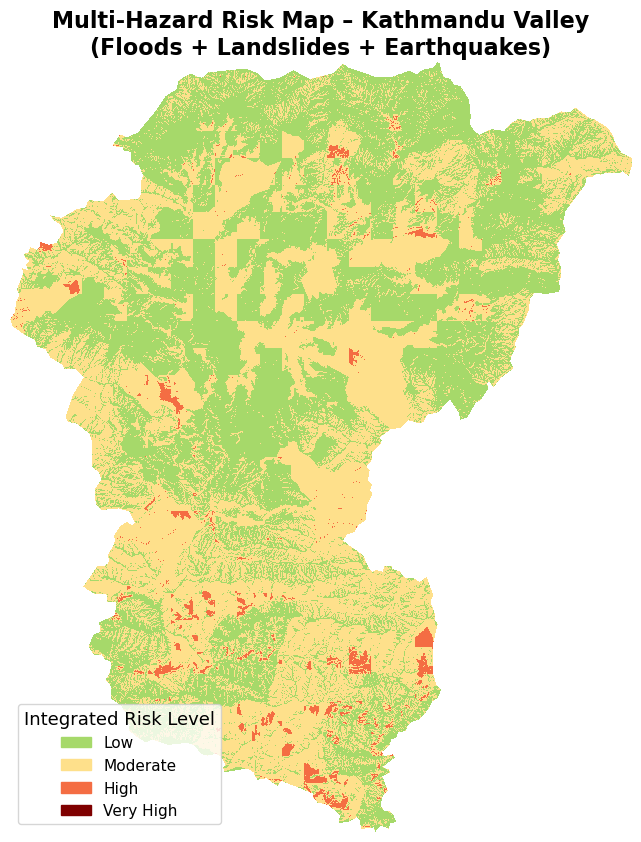

Multi-Hazard Statistics:
Low (1): 1359801 pixels
Moderate (2): 512738 pixels
High (3): 21011 pixels
Very High (4): 2 pixels

Average hazard values range: 1.00 - 3.67
Unique Landslide values: [0 1 2 3 4]
Masked? False
Landslide stats inside valley:
min: 1
max: 4
unique: [1 2 3 4]
Pixel 0: Flood=4, Seismic=1, Landslide=2, Avg=2.3333333333333335, Class=2
Pixel 1: Flood=0, Seismic=0, Landslide=0, Avg=0.0, Class=1
Pixel 2: Flood=0, Seismic=0, Landslide=0, Avg=0.0, Class=1
Pixel 3: Flood=0, Seismic=0, Landslide=0, Avg=0.0, Class=1
Pixel 4: Flood=4, Seismic=2, Landslide=4, Avg=3.3333333333333335, Class=3
Pixel 5: Flood=0, Seismic=0, Landslide=0, Avg=0.0, Class=1
Pixel 6: Flood=0, Seismic=0, Landslide=0, Avg=0.0, Class=1
Pixel 7: Flood=1, Seismic=2, Landslide=2, Avg=1.6666666666666667, Class=2
Pixel 8: Flood=0, Seismic=0, Landslide=0, Avg=0.0, Class=1
Pixel 9: Flood=0, Seismic=0, Landslide=0, Avg=0.0, Class=1


In [10]:
import geopandas as gpd
import rasterio
import rasterio.mask
from rasterio.features import rasterize, geometry_mask
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches

# --- 1. Lade alle Daten ---
flood = gpd.read_file("output/floods.gpkg")
seismic = gpd.read_file("output/earthquake_hazards.gpkg")
valley = gpd.read_file("input1/kathmandu_valley_reprojected.gpkg")
ls_raster_path = "output/landslide_hazard.tif"

# CRS vereinheitlichen
crs = flood.crs
seismic = seismic.to_crs(crs)

with rasterio.open(ls_raster_path) as src:
    out_image, out_transform = rasterio.mask.mask(
        src, valley.geometry, crop=True, filled=True
    )
    out_meta = src.meta.copy()

ls_data = out_image[0]

# Valley-Maske erstellen (True = außerhalb Valley)
mask_polygon = geometry_mask(
    valley.geometry,
    out_shape=ls_data.shape,
    transform=out_transform,
    invert=False
)

# Kopie zum Bereinigen als float anlegen
ls_clean = ls_data.astype(float).copy()

# Valley-Maske
mask_polygon = geometry_mask(
    valley.geometry,
    out_shape=ls_data.shape,
    transform=out_transform,
    invert=False
)

# Innerhalb Valley: fehlende oder <1 → Low
inside_valley = ~mask_polygon
ls_clean[(inside_valley) & (ls_clean < 1)] = 1

# Außerhalb Valley: NaN
ls_clean[mask_polygon] = np.nan


print("Unique Landslide values (bereinigt):", np.unique(ls_clean[inside_valley]))


# --- 3. Hazard-Werte: 1=Low, 2=Moderate, 3=High, 4=Very High ---
hazard_dict = {"Low": 1, "Moderate": 2, "High": 3, "Very High": 4}

# --- 4. Flood rasterisieren ---
flood_shapes = [(geom, hazard_dict[haz]) for geom, haz in zip(flood.geometry, flood["hazard"])]
flood_raster = rasterize(
    flood_shapes,
    out_shape=out_image.shape[1:],
    transform=out_transform,
    fill=0,
    dtype=np.uint8
)

# --- 5. Seismic rasterisieren ---
seismic_shapes = [(geom, hazard_dict[haz]) for geom, haz in zip(seismic.geometry, seismic["hazard"])]
seismic_raster = rasterize(
    seismic_shapes,
    out_shape=out_image.shape[1:],
    transform=out_transform,
    fill=0,
    dtype=np.uint8
)

# --- 6. Landslide bereits klassifiziert (1-4) ---
# Falls MaskedArray, extrahiere Daten
if isinstance(ls_data, np.ma.MaskedArray):
    ls_values = ls_data.data.copy()
else:
    ls_values = ls_data.copy()

# Bereiche innerhalb Valley ohne Daten auf 1 (Low) setzen
inside_valley = ~mask_polygon
ls_values[inside_valley & (ls_values < 1)] = 1

# --- 7. Multi-Hazard berechnen (Durchschnitt) ---
# Alle drei Raster auf float konvertieren
flood_float = flood_raster.astype(float)
seismic_float = seismic_raster.astype(float)
ls_float = ls_values.astype(float)


hazard_stack = np.stack([
    flood_raster.astype(float),
    seismic_raster.astype(float),
    ls_clean  # ist schon float
], axis=0)

multi_hazard_avg = np.nanmean(hazard_stack, axis=0)  # NaN = außerhalb Valley


# NaN zurück auf 0
multi_hazard_avg = np.nan_to_num(multi_hazard_avg, nan=0.0)

# --- 8. Klassifizierung in 4 Kategorien ---
multi_hazard = np.zeros_like(multi_hazard_avg, dtype=np.uint8)
multi_hazard[multi_hazard_avg <= 1.5] = 1  # Low
multi_hazard[(multi_hazard_avg > 1.5) & (multi_hazard_avg <= 2.5)] = 2  # Moderate
multi_hazard[(multi_hazard_avg > 2.5) & (multi_hazard_avg <= 3.5)] = 3  # High
multi_hazard[multi_hazard_avg > 3.5] = 4  # Very High

# Maske außerhalb Valley anwenden
multi_hazard_masked = np.ma.array(multi_hazard, mask=mask_polygon)

# --- 9. Farben und Plot ---
colors = ["#a6d96a", "#fee08b", "#f46d43", "#7f0000"]
labels = ["Low", "Moderate", "High", "Very High"]
cmap = ListedColormap(colors)
cmap.set_bad(color='white', alpha=0)

fig, ax = plt.subplots(figsize=(12, 10))
im = ax.imshow(multi_hazard_masked, cmap=cmap, vmin=1, vmax=4, interpolation='nearest')
ax.set_title("Multi-Hazard Risk Map – Kathmandu Valley\n(Floods + Landslides + Earthquakes)", 
             fontsize=16, fontweight='bold')
ax.set_axis_off()

# Legende
legend_patches = [mpatches.Patch(color=colors[i], label=labels[i]) for i in range(4)]
ax.legend(
    handles=legend_patches,
    title="Integrated Risk Level",
    loc="lower left",
    fontsize=11,
    title_fontsize=13
)

plt.show()

# --- 10. Speichern ---
out_meta.update({
    'dtype': np.uint8,
    'nodata': 0
})

with rasterio.open("output/multi_hazard_risk.tif", "w", **out_meta) as dst:
    dst.write(multi_hazard, 1)

# --- Debug Info ---
print("Multi-Hazard Statistics:")
print(f"Low (1): {(multi_hazard == 1).sum()} pixels")
print(f"Moderate (2): {(multi_hazard == 2).sum()} pixels")
print(f"High (3): {(multi_hazard == 3).sum()} pixels")
print(f"Very High (4): {(multi_hazard == 4).sum()} pixels")
print(f"\nAverage hazard values range: {multi_hazard_avg[multi_hazard_avg > 0].min():.2f} - {multi_hazard_avg[multi_hazard_avg > 0].max():.2f}")

print("Unique Landslide values:", np.unique(ls_data))
print("Masked?", isinstance(ls_data, np.ma.MaskedArray))
mask_polygon = geometry_mask(
    valley.geometry,
    out_shape=out_image.shape[1:],
    transform=out_transform,
    invert=False
)
inside_valley = ~mask_polygon
ls_values[inside_valley & (ls_values < 1)] = 1
print("Landslide stats inside valley:")
print("min:", ls_values[inside_valley].min())
print("max:", ls_values[inside_valley].max())
print("unique:", np.unique(ls_values[inside_valley]))
# Beispiel: Pixelweise checken
for i in range(10):
    r, c = np.random.randint(0, multi_hazard.shape[0]), np.random.randint(0, multi_hazard.shape[1])
    print(f"Pixel {i}: Flood={flood_raster[r,c]}, Seismic={seismic_raster[r,c]}, Landslide={ls_values[r,c]}, Avg={multi_hazard_avg[r,c]}, Class={multi_hazard[r,c]}")


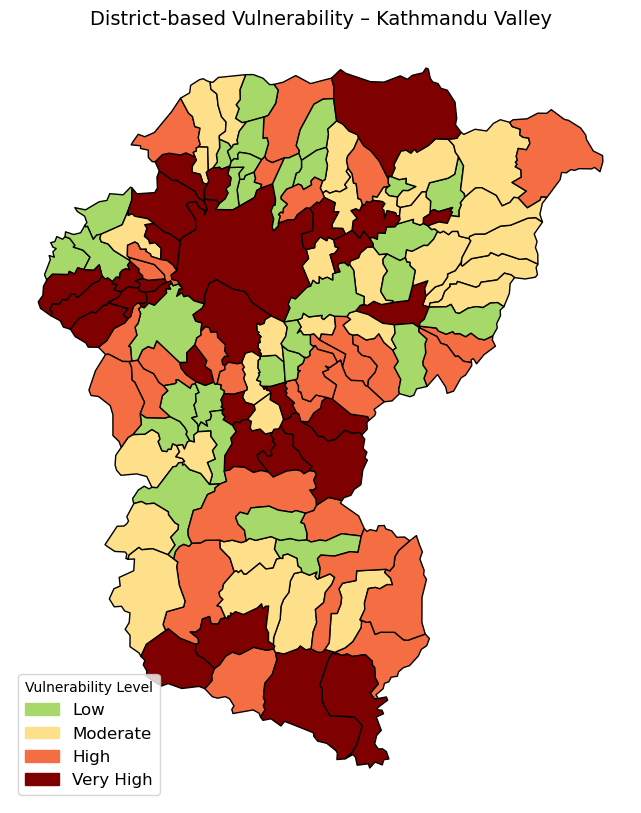

            NAME_4  building_count    road_length  healthcare_count  \
0        Bageswari            1349   64060.034854                 0   
1           Balkot            3379   59312.852991                13   
2    BhaktapurN.P.           14944  130762.095959                67   
3    Changunarayan            1569   68241.011887                 0   
4         Chhaling            2311   86832.313999                 0   
..             ...             ...            ...               ...   
114      Sunakothi            1957   42682.874512                 3   
115         Thaiba            1532   26790.078751                 1   
116         Thecho            2305   43826.787699                 1   
117   Thuladurlung             619   42656.818641                 0   
118      Tikathali            1904   54621.427905                 1   

     building_density  road_density  healthcare_density  vuln_score vuln_class  
0            0.000144      0.006828        0.000000e+00    0.47423

In [11]:
# Load layers
districts = gpd.read_file("input1/kathmandu_valley_districs.gpkg")
buildings = gpd.read_file("input1/exposure/kathmandu_buildings_reprojected.gpkg")
roads = gpd.read_file("input1/exposure/roads_kathmandu.gpkg")
healthcare = gpd.read_file("input1/exposure/Healtcare_reprojected.gpkg")

# Harmonize CRS
crs = districts.crs
buildings = buildings.to_crs(crs)
roads = roads.to_crs(crs)
healthcare = healthcare.to_crs(crs)

# Calculate district area
districts["area"] = districts.geometry.area

# Calculate indicators per district
districts["building_count"] = districts.geometry.apply(lambda x: buildings.within(x).sum())
districts["road_length"] = districts.geometry.apply(lambda x: roads[roads.intersects(x)].geometry.length.sum())
districts["healthcare_count"] = districts.geometry.apply(lambda x: healthcare.within(x).sum())

# Calculate density
districts["building_density"] = districts["building_count"] / districts["area"]
districts["road_density"] = districts["road_length"] / districts["area"]
districts["healthcare_density"] = districts["healthcare_count"] / districts["area"]

# Logarithmic transformation
districts["bld_log"] = np.log1p(districts["building_density"])
districts["road_log"] = np.log1p(districts["road_density"])
districts["health_log"] = np.log1p(districts["healthcare_density"])

# Normalize 0-1
def normalize(series, invert=False):
    if series.max() == series.min():
        return np.zeros_like(series)
    norm = (series - series.min()) / (series.max() - series.min())
    return 1 - norm if invert else norm

districts["bld_norm"] = normalize(districts["bld_log"])
districts["road_norm"] = normalize(districts["road_log"], invert=True)
districts["health_norm"] = normalize(districts["health_log"], invert=True)

# Calculate vulnerability score (weighted)
w_bld = 0.5
w_road = 0.25
w_health = 0.25

districts["vuln_score"] = (
    districts["bld_norm"] * w_bld +
    districts["road_norm"] * w_road +
    districts["health_norm"] * w_health
)

# Classify into 4 categories (quantiles)
labels = ["Low", "Moderate", "High", "Very High"]
districts["vuln_class"] = pd.qcut(districts["vuln_score"], q=4, labels=labels)

# Plot map
colors = ["#a6d96a", "#fee08b", "#f46d43", "#7f0000"]
cmap = ListedColormap(colors)

fig, ax = plt.subplots(figsize=(10, 10))
districts.plot(column="vuln_class", cmap=cmap, legend=False, ax=ax, edgecolor="black")

# Legend
legend_patches = [mpatches.Patch(color=colors[i], label=labels[i]) for i in range(4)]
ax.legend(handles=legend_patches, title="Vulnerability Level", loc="lower left", fontsize=12)
ax.set_title("District-based Vulnerability – Kathmandu Valley", fontsize=14)
ax.set_axis_off()
plt.show()

# Debug info
print(districts[["NAME_4", "building_count", "road_length", "healthcare_count",
                 "building_density", "road_density", "healthcare_density",
                 "vuln_score", "vuln_class"]])

# Save output
districts.to_file("output/kathmandu_vulnerability.gpkg", layer="vulnerability", driver="GPKG")

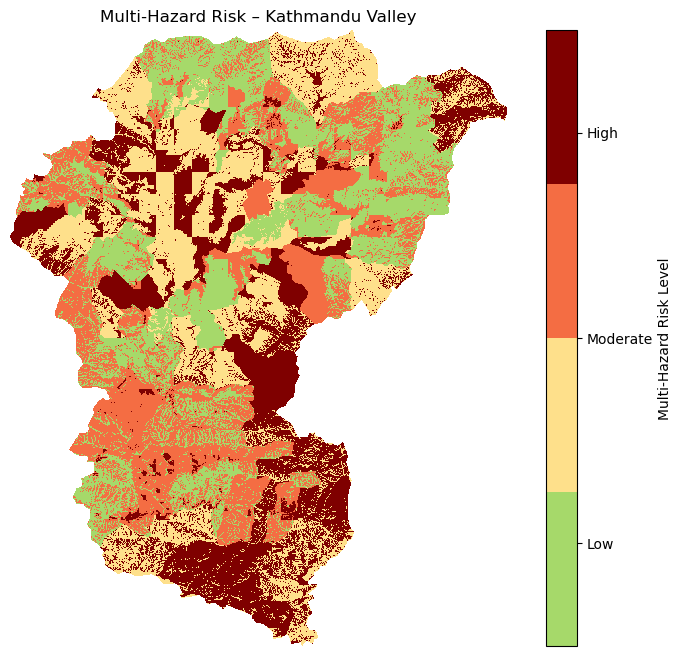

In [12]:
# Input paths
hazard_path = "output/multi_hazard_risk.tif"
vuln_path = "output/kathmandu_vulnerability.gpkg"
out_path = "output/risk_map.tif"

# Open hazard raster
with rasterio.open(hazard_path) as hazard_src:
    hazard = hazard_src.read(1)
    hazard_meta = hazard_src.meta.copy()
    hazard_nodata = hazard_src.nodata

# Load vulnerability
vuln = gpd.read_file(vuln_path, layer="vulnerability")

# Rasterize vulnerability
shapes = ((geom, value) for geom, value in zip(vuln.geometry, vuln["vuln_score"]))
vuln_raster = rasterio.features.rasterize(
    shapes=shapes,
    out_shape=hazard.shape,
    transform=hazard_meta["transform"],
    fill=np.nan,
    dtype="float32"
)

# Calculate risk (Hazard × Vulnerability)
risk = hazard.astype("float32") * vuln_raster

# Handle NoData
risk[hazard == hazard_nodata] = np.nan
risk[np.isnan(vuln_raster)] = np.nan

# Classify (Low-Very High, quantiles)
valid = risk[~np.isnan(risk)]
bins = np.nanquantile(valid, [0, 0.25, 0.5, 0.75, 1.0])
labels = ["Low", "Moderate", "High", "Very High"]
risk_class = np.digitize(risk, bins[1:], right=True)
risk_class = np.where(np.isnan(risk), np.nan, risk_class)

# Save output
hazard_meta.update(dtype="float32", nodata=np.nan)
with rasterio.open(out_path, "w", **hazard_meta) as dst:
    dst.write(risk, 1)

# Visualization
colors = ["#a6d96a", "#fee08b", "#f46d43", "#7f0000"]
cmap = ListedColormap(colors)

plt.figure(figsize=(10, 8))
im = plt.imshow(risk_class, cmap=cmap, interpolation="nearest")
cbar = plt.colorbar(im, ticks=[0.5, 1.5, 2.5, 3.5])
cbar.ax.set_yticklabels(labels)
cbar.set_label("Multi-Hazard Risk Level")
plt.title("Multi-Hazard Risk – Kathmandu Valley")
plt.axis("off")
plt.show()


Berechne dominante Risikoklasse pro Distrikt...
  District_0: Low (81.6%) – Erwartungswert
  District_1: Moderate (2.0%) – Erwartungswert
  District_2: High (1.7%) – Erwartungswert
  District_3: High (90.7%) – Erwartungswert
  District_4: Low (77.5%) – Erwartungswert
  District_5: Moderate (73.1%) – Erwartungswert
  District_6: Very High (96.7%) – Erwartungswert
  District_7: Low (80.2%) – Erwartungswert
  District_8: High (98.0%) – Erwartungswert
  District_9: Moderate (0.7%) – Erwartungswert
  District_10: High (94.5%) – Erwartungswert
  District_11: Low (53.5%) – Erwartungswert
  District_12: Moderate (0.0%) – Erwartungswert
  District_13: Moderate (94.4%) – Erwartungswert
  District_14: Moderate (1.1%) – Erwartungswert
  District_15: High (2.2%) – Erwartungswert
  District_16: Moderate (0.0%) – Erwartungswert
  District_17: Moderate (1.2%) – Erwartungswert
  District_18: Moderate (0.0%) – Erwartungswert
  District_19: Moderate (0.0%) – Erwartungswert
  District_20: Moderate (0.3%)

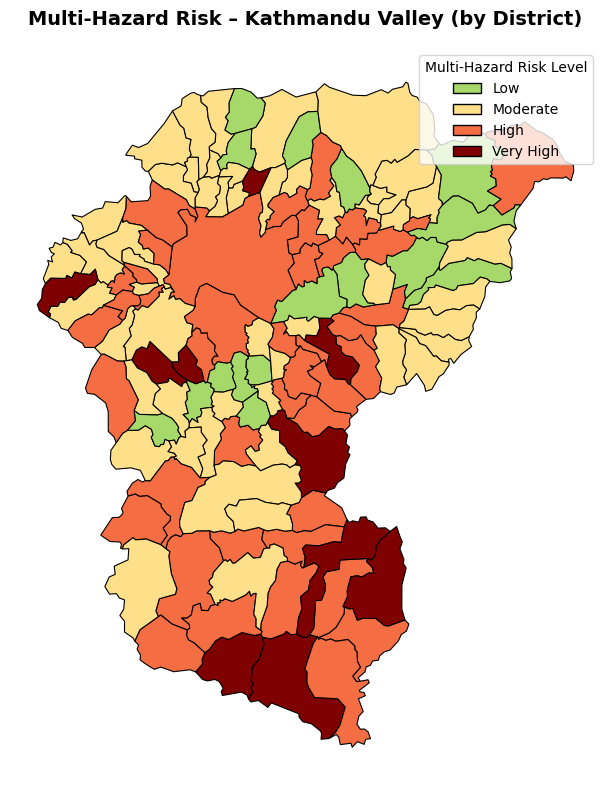


✓ Visualisierung abgeschlossen!


In [14]:
import geopandas as gpd
import rasterio
import rasterio.mask
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from collections import Counter

# laod data
risk_raster_path = "output/risk_map.tif"
districts_path = "input1/kathmandu_valley_districs.gpkg"
out_path = "output/district_risk_map.gpkg"

# open risk dataset
with rasterio.open(risk_raster_path) as risk_src:
    risk = risk_src.read(1)
    risk_meta = risk_src.meta.copy()
    risk_nodata = risk_src.nodata
    risk_transform = risk_src.transform
    risk_crs = risk_src.crs

# Classify
valid = risk[~np.isnan(risk)]
bins = np.nanquantile(valid, [0, 0.25, 0.5, 0.75, 1.0])
labels = ["Low", "Moderate", "High", "Very High"]
risk_class = np.digitize(risk, bins[1:], right=True) 
risk_class = np.where(np.isnan(risk), np.nan, risk_class)

districts = gpd.read_file(districts_path)

if districts.crs != risk_crs:
    print(f"Reprojiziere Districts von {districts.crs} nach {risk_crs}")
    districts = districts.to_crs(risk_crs)

# calculating dominant risk class
district_risks = []

print("\nBerechne dominante Risikoklasse pro Distrikt...")

for idx, district in districts.iterrows():
    district_name = district.get('DISTRICT', district.get('NAME', district.get('name', f'District_{idx}')))
    
    try:
        with rasterio.open(risk_raster_path) as src:
            out_image, out_transform = rasterio.mask.mask(
                src, [district.geometry], crop=True, all_touched=True, nodata=np.nan
            )
        
        # extract risk values
        masked_risk = out_image[0]
        valid_values = masked_risk[~np.isnan(masked_risk)]
        
        if len(valid_values) > 0:
            # classify
            district_risk_values = np.digitize(valid_values, bins[1:], right=True)
            
            # class frewuencx
            counter = Counter(district_risk_values)
            total_pixels = len(district_risk_values)
            
            # weighted expected value
            weighted_sum = sum(cls * count for cls, count in counter.items())
            mean_risk = weighted_sum / total_pixels
            dominant_class = int(round(mean_risk))
            
            dominant_label = labels[dominant_class]
            percentage = (counter[dominant_class] / total_pixels) * 100
            
            print(f"  {district_name}: {dominant_label} ({percentage:.1f}%) – Erwartungswert")
        
        else:
            dominant_class = np.nan
            dominant_label = "No Data"
            print(f"  {district_name}: Keine Daten")
        
        district_risks.append({
            'geometry': district.geometry,
            'district_name': district_name,
            'risk_class': dominant_class,
            'risk_label': dominant_label
        })
        
    except Exception as e:
        print(f"  Fehler bei {district_name}: {e}")
        district_risks.append({
            'geometry': district.geometry,
            'district_name': district_name,
            'risk_class': np.nan,
            'risk_label': "No Data"
        })

# save
district_risk_gdf = gpd.GeoDataFrame(district_risks, crs=risk_crs)
district_risk_gdf.to_file(out_path, driver="GPKG")

print(f"\n✓ District-Risk-Map gespeichert: {out_path}")

colors = ["#a6d96a", "#fee08b", "#f46d43", "#7f0000"]
cmap_dict = {0: colors[0], 1: colors[1], 2: colors[2], 3: colors[3]}

fig, ax = plt.subplots(figsize=(10, 8))

# color districts depending on riskclass
for idx, row in district_risk_gdf.iterrows():
    if not np.isnan(row['risk_class']):
        color = cmap_dict[int(row['risk_class'])]
    else:
        color = 'white'
    
    district_risk_gdf[district_risk_gdf.index == idx].plot(
        ax=ax, 
        color=color, 
        edgecolor='black', 
        linewidth=0.8
    )

# create legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor=colors[0], edgecolor='black', label='Low'),
    Patch(facecolor=colors[1], edgecolor='black', label='Moderate'),
    Patch(facecolor=colors[2], edgecolor='black', label='High'),
    Patch(facecolor=colors[3], edgecolor='black', label='Very High')
]
ax.legend(handles=legend_elements, loc='upper right', title='Multi-Hazard Risk Level')

ax.set_title("Multi-Hazard Risk – Kathmandu Valley (by District)", fontsize=14, fontweight='bold')
ax.axis('off')

plt.tight_layout()
plt.show()

print("\n✓ Visualisierung abgeschlossen!")